# Разработка концепции ранжирования районов города по уровню самодостаточности, на основе больших данных

Цель задачи — разработка концепции по определению уровня самодостаточности районов города Москвы (оснащенность районов объектами социальной, развлекательной, спортивной и пр. инфраструктурой) на примере нескольких районов города, основываясь на анализе больших данных и с учетом дальнейшего масштабирования предлагаемого подхода на все районы города Москвы.

В качестве требований по решению задачи, должны быть произведены:
1. Анализ используемых источников и данных - анализ имеющегося массива данных по численности населения и/или иных данных полученных из различных источников, необходимых для формирования решения;
2. Описание подхода и форматов работы с данными – обоснование используемых данных;
3. Построение стратегии по сбору данных и выводов по работе и использованию имеющихся данных (включая анализ доступа к данным);
4. Формирование концепции по определению уровня самодостаточности районов;
5. Апробация определения уровня самодостаточности районов города Москвы на примере двух и более районов одного округа города Москвы;
6. Проведение оценки применимости (масштабирования) разработанной концепции к определению уровня самодостаточности на примере одного округа города Москвы;
8. Формирование предложений возможных управленческих решений, решаемых с применением разработанной концепции.
9. Оформить визуально ранжирование районов одного из округов города Москвы по уровню самодостаточности.

## Описание источников, инструментов и концепции

Работа будет выполняться на основе данных из следующих источников:
- ДИТ Москвы, 
- портал открытых данных Правительства Москвы [data.mos.ru](http://data.mos.ru),
- [OpenStreetMap](https://www.openstreetmap.org/#map=13/55.7444/37.6253) - веб-сервис геопространственных данных.

Для обработки геопространственных данных использована свободная геоинформационная система [QGIS](https://www.qgis.org/ru/site/about/).

Нормы по количеству и объему услуг, предоставляемых населению, взяты из нормативно-правовых актов Правительства Москвы:
- [Постановление Правительства Москвы от 23 декабря 2015 года N 945-ПП](https://docs.cntd.ru/document/537986033) "Об утверждении региональных нормативов градостроительного проектирования города Москвы в области транспорта, автомобильных дорог регионального или межмуниципального значения",
- [Постановление Правительства Москвы от 21 декабря 2021 года N 2152-ПП](https://docs.cntd.ru/document/727795416) "Об утверждении нормативов градостроительного проектирования города Москвы в области торговли, обслуживания и обеспечения комфортных и благоприятных условий проживания граждан в объектах жилого назначения"
- [Постановление Правительства Москвы от 22 сентября 2020 года N 1557-ПП](https://docs.cntd.ru/document/565881464) "Об утверждении нормативов градостроительного проектирования города Москвы в области физической культуры и спорта"
- [Постановление Правительства Москвы от 21 декабря 2021 года N 2150-ПП](https://docs.cntd.ru/document/727795415) "Об утверждении нормативов градостроительного проектирования города Москвы в области здравоохранения"
- [Постановление Правительства Москвы от 21 декабря 2021 года N 2151-ПП](https://docs.cntd.ru/document/727795424) "Об утверждении нормативов градостроительного проектирования города Москвы в области образования"

Исследование будет проведено для территории Старой Москвы.

Материалы, использыемые в работе, размещены по ссылке [https://disk.yandex.ru/d/s-dqoQN9D0birQ](https://disk.yandex.ru/d/s-dqoQN9D0birQ)

**Концепция определения самодостаточности районов:**
1) Выделение основных сфер деятельности населения: образование, социальная сфера, транспорт, здравоохранение, физическая культура и спорт.

2) Определение стандартов городского проектирования для объектов в каждой сфере в соответствии с нормативными документами.

3) Сбор данных по объектам, входящим в сферы деятельности, по каждому району. В приоритете данные, по которым определены нормы в нормативных документах.

4) Формирование признаков для исследования - приведение к единой размерности (например, значение на 1000 жителей, на кв.км), желательно приведение данных к интервальной шкале и соблюдение принципа чем выше значение, тем лучше показатель, так в дальнейшем будет проще определить ранг.

5) Кластеризация данных и определение ранга самодостаточности районов по каждой сфере.

6) Кластеризация данных о самодостаточности в каждой сфере и определение ранга самодостаточности районов.   

Кластеризация будет проводится с помощью инструмента KMeans библиотеки scikit-learn. Этот инструмент реализует метод k-средних. Действие алгоритма таково, что он стремится минимизировать суммарное квадратичное отклонение точек кластеров от центров этих кластеров

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [2]:
# функция для просмотра общей информации по датасетам
def data_info(data, name, zid):
    print('\033[1m' + 'Информация о датасете:', name + '\033[0m')
    print()
    display(data.info())
    display(data.describe().T)
    print('--------------------------------------------------------------------------------')
    print('\033[1m' + 'Подсчет явных дубликатов в датасете:' + '\033[0m', data.duplicated().sum())
    print('--------------------------------------------------------------------------------')
    try:
        print('\033[1m' + 'Количество уникальных значений поля zid:' + '\033[0m',
              data[zid].nunique())
    except:
        print('\033[1m' + 'В датасете отсутствует поле zid' + '\033[0m')

In [3]:
# функция для формирования данных по дням недели
def median_customers(feature):
    data = CDensity_202109.pivot_table(index='zid', columns='weekday',
                                       values=feature,
                                       aggfunc='mean').reset_index()
    data.columns = ['zid', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
    return data

In [4]:
# функция для формирования датасетов с данными по дням недели
def median_customers_df(feature, name):
    df = median_customers(feature)
    df[f'weekdays_{name}'] = df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].mean(axis=1)
    df[f'weekends_{name}'] = df[['Saturday', 'Sunday']].mean(axis=1)
    
    return df[['zid', f'weekdays_{name}', f'weekends_{name}']]

## Изучение исходных данных

In [5]:
# загрузка табличных данных
CMatrix_Home_work_202109 = pd.read_csv("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/04_CMatrix_Home_work_202109.csv")
Clocation_202109 = pd.read_csv("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/01_Clocation_202109.csv")
CDensity_202109 = pd.read_csv("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/02_CDensity_202109.csv")

In [6]:
# загрузка табличных данных, содержащих геопространственную информацию
gdf = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/adm2fishnet.csv", sep=';',
                    encoding='UTF-8')
gdf.crs = 'epsg:4326'   # установка системы координат

В исходных данных присутствует один большой датасет, который нецелесообразно загружать целиком, выберем из него данные только по тем секторам, которые будут использованы в исследовании.

In [7]:
# сектора на территорию Старой Москвы
zid = list(map(int, gdf.loc[gdf.sub_ter == 'Старая Москва', 'cell_zid'].unique()))

In [8]:
len(zid)

5041

In [9]:
# выборка данных из большого датасета
csv_file = "C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/03_CMatrix_202109.csv"
gen = pd.read_csv(csv_file, chunksize=1000000)
CMatrix_202109 = pd.concat((x.query("departure_zid == @zid") for x in gen), ignore_index=True)

Данные ДИТ Москвы:
- **CMatrix_Home_work_202109** - матрица корреспонденции дом-работа по секторам
- **Clocation_202109** - изменение численности населения по секторам
- **CDensity_202109** - изменение плотности населения по секторам
- **CMatrix_202109** - динамика перемещения населения по секторам
- **gdf** - административно-территориальное деление + деление по секторам

In [10]:
Clocation_202109.head()

,dt,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_night
0,2021-09-30,32909,1,0,0,3
1,2021-09-30,32910,2,0,0,4
2,2021-09-30,33261,0,0,0,2
3,2021-09-30,33262,1,0,0,5
4,2021-09-30,33263,0,0,0,4


In [11]:
CDensity_202109.head()

,dt,time_interval,zid,median_customers_cnt_total,median_customers_cnt_long,median_customers_cnt_work,median_customers_cnt_loc,median_customers_cnt_long_work,median_customers_cnt_long_loc
0,2021-09-01,1,32909,1.0,1.0,0.0,0.0,0.0,0.0
1,2021-09-01,1,32910,1.0,1.0,0.0,0.0,0.0,0.0
2,2021-09-01,1,33261,2.0,2.0,0.0,0.0,0.0,0.0
3,2021-09-01,1,33262,3.0,3.0,0.0,0.0,0.0,0.0
4,2021-09-01,1,33264,1.0,1.0,0.0,0.0,0.0,0.0


In [12]:
CDensity_202109.dt.unique()

array(['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
       '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
       '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
       '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
       '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
       '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
       '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28',
       '2021-09-29', '2021-09-30'], dtype=object)

In [13]:
CMatrix_202109.head()

,is_vacation,time_interval,departure_zid,arrival_zid,median_customers_cnt,median_customers_cnt_metro,median_customers_cnt_home_work,median_customers_cnt_work_home
0,0,1,75061,48428,0.0,0.0,0.0,0.0
1,0,1,75061,50242,0.0,0.0,0.0,0.0
2,0,1,75061,50243,0.0,0.0,0.0,0.0
3,0,1,75061,51483,0.0,0.0,0.0,0.0
4,0,1,75061,54580,1.0,0.0,0.0,0.0


In [14]:
gdf.head()

,WKT,cell_zid,adm_name,okrug_name,sub_ter,geometry
0,MULTIPOLYGON (((38.6495389842383 54.2597139180...,0,Серебряные пруды,,Московская область,"MULTIPOLYGON (((38.64954 54.25971, 38.65500 54..."
1,MULTIPOLYGON (((38.6549362377517 54.2572466621...,1,Серебряные пруды,,Московская область,"MULTIPOLYGON (((38.65494 54.25725, 38.65500 54..."
2,MULTIPOLYGON (((38.6625773861122 54.2560891872...,2,Серебряные пруды,,Московская область,"MULTIPOLYGON (((38.66258 54.25609, 38.66268 54..."
3,MULTIPOLYGON (((38.670279125503 54.25708620909...,3,Серебряные пруды,,Московская область,"MULTIPOLYGON (((38.67028 54.25709, 38.67035 54..."
4,MULTIPOLYGON (((38.6779821287111 54.2581143832...,4,Серебряные пруды,,Московская область,"MULTIPOLYGON (((38.67798 54.25811, 38.67802 54..."


In [15]:
data_info(CMatrix_Home_work_202109, 'CMatrix_Home_work_202109', zid='home_zid')

Информация о датасете: CMatrix_Home_work_202109

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439531 entries, 0 to 1439530
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   dt             1439531 non-null  object
 1   home_zid       1439531 non-null  int64 
 2   work_zid       1439531 non-null  int64 
 3   customers_cnt  1439531 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 43.9+ MB


None

,count,mean,std,min,25%,50%,75%,max
home_zid,1439531.0,105010.970285,14668.642804,32909.0,95605.0,105732.0,116614.0,139343.0
work_zid,1439531.0,105855.628548,14371.691282,-1.0,99797.0,108090.0,114392.0,139343.0
customers_cnt,1439531.0,5.638694,82.445303,1.0,1.0,1.0,2.0,6099.0


--------------------------------------------------------------------------------
Подсчет явных дубликатов в датасете: 0
--------------------------------------------------------------------------------
Количество уникальных значений поля zid: 6961


In [16]:
data_info(Clocation_202109, 'Clocation_202109', zid='zid')

Информация о датасете: Clocation_202109

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10169 entries, 0 to 10168
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dt                   10169 non-null  object
 1   zid                  10169 non-null  int64 
 2   customers_cnt_home   10169 non-null  int64 
 3   customers_cnt_job    10169 non-null  int64 
 4   customers_cnt_day    10169 non-null  int64 
 5   customers_cnt_night  10169 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 476.8+ KB


None

,count,mean,std,min,25%,50%,75%,max
zid,10169.0,83628.764775,26456.747168,32909.0,62016.0,84289.0,105760.0,139343.0
customers_cnt_home,10169.0,832.135313,1434.873854,0.0,0.0,53.0,1036.0,10601.0
customers_cnt_job,10169.0,441.484610,891.864017,0.0,7.0,48.0,589.0,24654.0
customers_cnt_day,10169.0,681.393746,1212.021484,0.0,7.0,63.0,953.0,27365.0
customers_cnt_night,10169.0,1220.291474,2009.005735,0.0,17.0,139.0,1600.0,21185.0


--------------------------------------------------------------------------------
Подсчет явных дубликатов в датасете: 0
--------------------------------------------------------------------------------
Количество уникальных значений поля zid: 10169


In [17]:
data_info(CDensity_202109, 'CDensity_202109', zid='zid')

Информация о датасете: CDensity_202109

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224897 entries, 0 to 1224896
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   dt                              1224897 non-null  object 
 1   time_interval                   1224897 non-null  int64  
 2   zid                             1224897 non-null  int64  
 3   median_customers_cnt_total      1224897 non-null  float64
 4   median_customers_cnt_long       1224897 non-null  float64
 5   median_customers_cnt_work       1224897 non-null  float64
 6   median_customers_cnt_loc        1224897 non-null  float64
 7   median_customers_cnt_long_work  1224897 non-null  float64
 8   median_customers_cnt_long_loc   1224897 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 84.1+ MB


None

,count,mean,std,min,25%,50%,75%,max
time_interval,1224897.0,2.501227,1.117443,1.0,2.0,3.0,4.0,4.0
zid,1224897.0,83503.004858,26496.844846,32909.0,61447.0,84270.0,105751.0,139343.0
median_customers_cnt_total,1224897.0,943.739596,1518.896152,1.0,15.5,133.5,1344.0,32531.5
median_customers_cnt_long,1224897.0,701.951693,1143.685659,0.0,12.0,93.5,949.0,24983.0
median_customers_cnt_work,1224897.0,96.947343,243.972302,0.0,0.0,6.0,102.5,15093.0
median_customers_cnt_loc,1224897.0,275.837575,518.221958,0.0,0.0,12.0,285.0,5741.5
median_customers_cnt_long_work,1224897.0,72.530744,175.906869,0.0,0.0,4.5,80.0,12771.0
median_customers_cnt_long_loc,1224897.0,227.322594,438.288343,0.0,0.0,9.0,223.5,5225.5


--------------------------------------------------------------------------------
Подсчет явных дубликатов в датасете: 0
--------------------------------------------------------------------------------
Количество уникальных значений поля zid: 10249


In [18]:
data_info(CMatrix_202109, 'CMatrix_202109', zid='departure_zid')

Информация о датасете: CMatrix_202109

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56062073 entries, 0 to 56062072
Data columns (total 8 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   is_vacation                     int64  
 1   time_interval                   int64  
 2   departure_zid                   int64  
 3   arrival_zid                     int64  
 4   median_customers_cnt            float64
 5   median_customers_cnt_metro      float64
 6   median_customers_cnt_home_work  float64
 7   median_customers_cnt_work_home  float64
dtypes: float64(4), int64(4)
memory usage: 3.3 GB


None

,count,mean,std,min,25%,50%,75%,max
is_vacation,56062073.0,0.361189,0.480345,0.0,0.0,0.0,1.0,1.0
time_interval,56062073.0,2.694552,1.030999,1.0,2.0,3.0,4.0,4.0
departure_zid,56062073.0,107410.208189,11562.675145,75061.0,99189.0,107511.0,116080.0,139343.0
arrival_zid,56062073.0,105452.196088,13871.079466,32909.0,96240.0,106340.0,115548.0,139343.0
median_customers_cnt,56062073.0,1.171488,10.749441,0.0,1.0,1.0,1.0,6412.5
median_customers_cnt_metro,56062073.0,0.230543,0.898458,0.0,0.0,0.0,0.0,1043.5
median_customers_cnt_home_work,56062073.0,0.028844,0.333671,0.0,0.0,0.0,0.0,177.0
median_customers_cnt_work_home,56062073.0,0.026334,0.323026,0.0,0.0,0.0,0.0,145.0


--------------------------------------------------------------------------------
Подсчет явных дубликатов в датасете: 0
--------------------------------------------------------------------------------
Количество уникальных значений поля zid: 4564


In [19]:
data_info(gdf.drop('geometry', axis=1), 'gdf', zid='cell_zid')

Информация о датасете: gdf

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203634 entries, 0 to 203633
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   WKT         203634 non-null  object
 1   cell_zid    203634 non-null  object
 2   adm_name    203634 non-null  object
 3   okrug_name  203634 non-null  object
 4   sub_ter     203634 non-null  object
dtypes: object(5)
memory usage: 7.8+ MB


None

,count,unique,top,freq
WKT,203634,203634,MULTIPOLYGON (((38.6495389842383 54.2597139180...,1
cell_zid,203634,189892,114417,5
adm_name,203634,206,Шатура,11100
okrug_name,203634,13,,189561
sub_ter,203634,3,Московская область,189561


--------------------------------------------------------------------------------
Подсчет явных дубликатов в датасете: 0
--------------------------------------------------------------------------------
Количество уникальных значений поля zid: 189892


In [20]:
gdf['cell_zid'] = gdf['cell_zid'].astype(int)

Данные не содержат дубликатов. В всех таблицах представлена информация о разном количестве секторов, по этой причине в дальнейшем могут образоваться пропуски в данных. 

In [21]:
# таблица с описанием признаков
describe = pd.read_excel("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/Описание признаков.xlsx",
                         sheet_name='описание')

## Формирование признаков для исследования

Из исходных данных необходимо сформировать признаки, которые будут применяться в исследовании.

In [22]:
# описание признаков, которые необходимо сформировать
describe.loc[(describe['Источник данных'] == 'ДИТ Москвы') | (describe['Источник данных'] == 'расчетное значение'),
             ['Наименование признака', 'Описание признака', 'Источник данных',]]\
        .sort_values('Источник данных')

,Наименование признака,Описание признака,Источник данных
0,adm_name,Район,ДИТ Москвы
9,weekends_work,Медианное количество работающих человек по вых...,ДИТ Москвы
8,weekdays_work,Медианное количество работающих человек по будням,ДИТ Москвы
7,weekends_loc,Медианное количество проживающих человек по вы...,ДИТ Москвы
6,weekdays_loc,Медианное количество проживающих человек по бу...,ДИТ Москвы
59,to_work,"Среднее время, за которое жители района добира...",ДИТ Москвы
4,night,Ночное население,ДИТ Москвы
3,day,Дневное население,ДИТ Москвы
2,home_and_work,Количество проживающих и работающих,ДИТ Москвы
1,area,Площадь,ДИТ Москвы


Нормы для расчетных значений определены в соответствии с нормативными документами.

### Количество работающего и проживающего в районе населения

В исходных данных информация распределена по секторам, однако, для исследования нам необходимы данные по районам, поэтому надо в исходную таблицу добавить наименования районов: район прожирания и район работы. Далее выберем информацию только по тем жителям, которые работают и живут в одном и том же районе. Данный показатель может говорить о самодостаточности района в плане трудоустройства населения. 

In [23]:
work_df = CMatrix_Home_work_202109.merge(gdf[['cell_zid', 'adm_name']], left_on='home_zid', right_on='cell_zid',
                                         how='left').rename({'adm_name': 'adm_name_home'}, axis=1)
work_df = work_df.merge(gdf[['cell_zid', 'adm_name']], left_on='work_zid', right_on='cell_zid',
                                         how='left').rename({'adm_name': 'adm_name_work'}, axis=1)

In [24]:
for_drop = []
for i in list(work_df.index):
    if work_df['adm_name_home'][i] == work_df['adm_name_work'][i]:
        for_drop.append(i)

In [25]:
# живущие и работающие в одном районе
work_df_same = work_df.query('index in @for_drop')
work_df_same.head()

,dt,home_zid,work_zid,customers_cnt,cell_zid_x,adm_name_home,cell_zid_y,adm_name_work
15,2021-09-30,33974,33621,1,33974,Роговское,33621.0,Роговское
20,2021-09-30,33977,34678,1,33977,Роговское,34678.0,Роговское
25,2021-09-30,33979,33979,12,33979,Чехов,33979.0,Чехов
28,2021-09-30,33979,33979,12,33979,Роговское,33979.0,Роговское
34,2021-09-30,33980,34331,1,33980,Роговское,34331.0,Роговское


In [26]:
# перечень секторов и количество человек, живущих и работающих в границах района
home_and_work = work_df_same.pivot_table(index='home_zid', values='customers_cnt', aggfunc='sum').reset_index()
home_and_work.columns = ['zid', 'home_and_work']
home_and_work.head()

,zid,home_and_work
0,33974,1
1,33977,1
2,33979,24
3,33980,1
4,34320,1


### Медианное количество работающего и проживающего населения по будням	и в выходные

Медианное количество человек по будням и в выходные дает представление о том, как изменяется количество работающего и проживающего населения района в зависимости от дня недели. Данный показатель может говорить о самодостаточности района в плане трудоустройства и социальной сферы.

In [27]:
# формирование признака с днями недели
CDensity_202109['dt'] = pd.to_datetime(CDensity_202109['dt'], format='%Y-%m-%d %H:%M:%S')
CDensity_202109['weekday'] = CDensity_202109['dt'].dt.day_name()

In [28]:
median_customers_cnt_work = median_customers_df('median_customers_cnt_work', name='work')
median_customers_cnt_loc = median_customers_df('median_customers_cnt_loc', name='loc') 

In [29]:
median_customers_cnt_loc.head()

,zid,weekdays_loc,weekends_loc
0,32909,0.0,0.0
1,32910,0.0,0.0
2,33261,0.0,0.0
3,33262,0.0,0.0
4,33263,0.0,0.0


In [30]:
median_customers_cnt_work.head()

,zid,weekdays_work,weekends_work
0,32909,0.0,0.0
1,32910,0.0,0.0
2,33261,0.0,0.0
3,33262,0.0,0.0
4,33263,0.0,0.0


### Дневное и ночное население

In [31]:
Clocation_202109.head()

,dt,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_night
0,2021-09-30,32909,1,0,0,3
1,2021-09-30,32910,2,0,0,4
2,2021-09-30,33261,0,0,0,2
3,2021-09-30,33262,1,0,0,5
4,2021-09-30,33263,0,0,0,4


In [32]:
day_night = Clocation_202109.pivot_table(index='zid', values=['customers_cnt_day',
                                                              'customers_cnt_night'], aggfunc='sum').reset_index()
day_night.columns = ['zid', 'day', 'night']

In [33]:
day_night['ratio_day_night'] = day_night['day'] / day_night['night']

In [34]:
day_night.head()

,zid,day,night,ratio_day_night
0,32909,0,3,0.0
1,32910,0,4,0.0
2,33261,0,2,0.0
3,33262,0,5,0.0
4,33263,0,4,0.0


### Среднее время в пути до работы

Рассчитаем среднее время в пути до работы в рабочие дни.

In [35]:
customers_to_work = CMatrix_202109.loc[CMatrix_202109.is_vacation == 0, :]\
                .pivot_table(index='departure_zid', columns='time_interval',
                             values='median_customers_cnt_home_work', aggfunc='sum').reset_index()

In [36]:
customers_to_work

time_interval,departure_zid,1,2,3,4
0,75061,29.0,63.5,7.0,7.5
1,75062,3.0,9.0,2.0,0.0
2,75063,1.0,10.5,3.0,1.0
3,75064,0.0,2.0,1.0,1.0
4,75681,39.5,183.5,30.5,19.0
...,...,...,...,...,...
4559,138913,1.0,1.0,0.0,0.0
4560,138914,2.0,8.5,2.0,0.0
4561,138915,0.5,6.0,0.0,0.0
4562,138916,2.0,4.0,1.5,0.0


In [37]:
# функция для расчета среднего времени в пути до работы в часах
def time_to_work(data):
    c1 = data[1] * 0.5 + data[2] + data[3] * 1.5 + data[4] * 2
    c2 = data[1] + data[2] + data[3] + data[4]
    return c1/c2

In [38]:
# среднее время в пути до работы в часах
customers_to_work['to_work'] = customers_to_work.apply(time_to_work, axis=1)

In [39]:
customers_to_work = customers_to_work[['departure_zid', 'to_work']]
customers_to_work.columns = ['zid', 'to_work']
customers_to_work.head()

,zid,to_work
0,75061,0.967290
1,75062,0.964286
2,75063,1.129032
3,75064,1.375000
4,75681,1.053211


In [40]:
del [CMatrix_Home_work_202109, Clocation_202109, CDensity_202109]
gc.collect()

1531

## Загрузка геоданных

Геообработка данных осуществлялась в соответствии с нормами из указанных постановлений Правительства Москвы.

In [41]:
# загрузка геоданных, сформированных в QGIS - формат shp
shops = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/shops_2_.shp", encoding='UTF-8')
service = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/service_2_.shp", encoding='UTF-8')
schools = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/schools_.shp", encoding='UTF-8')
food = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/food_2_.shp", encoding='UTF-8')
residential = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/residential_.shp", encoding='UTF-8')
public_post = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/post_office.shp", encoding='UTF-8')
public_police = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/police.shp", encoding='UTF-8')
public_bank = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/bank_.shp", encoding='UTF-8')
office = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/office_.shp", encoding='UTF-8')
health = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/health_.shp", encoding='UTF-8')
education = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/education_.shp", encoding='UTF-8')
sport = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/pitch_.shp", encoding='UTF-8')
art = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/art_.shp", encoding='UTF-8')
playground_area = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/playground_.shp", encoding='UTF-8')
promzona_area = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/promzona_.shp", encoding='UTF-8')
commertial_area = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/commercial_.shp", encoding='UTF-8')
parking_area = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/parking_.shp", encoding='UTF-8')
kindergarden = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/kindergarden.shp", encoding='UTF-8')
roads = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/roads_intersect.shp", encoding='UTF-8')
houses = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/bldng_apartments_.shp", encoding='UTF-8')
residential_metro2500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/metro2500_.shp", encoding='UTF-8')
residential_service500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/service500_.shp", encoding='UTF-8')
residential_school300 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/school300_.shp", encoding='UTF-8')
residential_art1500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/art1500_.shp", encoding='UTF-8')
residential_shops500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/shops500_.shp", encoding='UTF-8')
residential_playground300 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/playground300_.shp", encoding='UTF-8')
public_bank1500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/bank1500_.shp", encoding='UTF-8')
residential_food500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/food500_.shp", encoding='UTF-8')
public_police1500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/police1500_.shp", encoding='UTF-8')
residential_parks400 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/parks400_.shp", encoding='UTF-8')
public_post1500 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/post1500_.shp", encoding='UTF-8')
residential_metro700 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/metro700_.shp", encoding='UTF-8')
residential_kindergarden300 = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/kindergarden300_.shp", encoding='UTF-8')

In [42]:
gdf_districts = gpd.read_file("C:/Users/79853/Documents/datascience/hacks_ai/ДИТ Москвы/shp/districs42.shp", encoding='UTF-8')

In [43]:
# описание загруженных геоданных
describe.loc[(describe['Источник данных'] == 'OpenStreetMaps') | (describe['Источник данных'] == 'геообработка') |
              (describe['Источник данных'] == 'Mos.ru'),
             ['Наименование признака', 'Описание признака', 'Источник данных',
              'Номер постановления Правительства Москвы']]\
        .sort_values('Источник данных')

,Наименование признака,Описание признака,Источник данных,Номер постановления Правительства Москвы
45,shops,Предприятия торговли - магазины (продовольстве...,Mos.ru,2152-ПП
41,service,Предприятия бытового обслуживания (приемные пу...,Mos.ru,2152-ПП
39,schools,Школы,Mos.ru,2151-ПП
33,food,"Общественное питание - рестораны, бары, пабы, ...",Mos.ru,2152-ПП
12,residential,Жилые кварталы,OpenStreetMaps,NaN
54,public_post,Почтовые отделения,OpenStreetMaps,2152-ПП
51,public_police,Полицейские участки,OpenStreetMaps,2152-ПП
48,public_bank,Отделения банков,OpenStreetMaps,2152-ПП
44,office,"Офисы – помещения/здания, в которых работают с...",OpenStreetMaps,NaN
40,health,"Здоровье – поликлиники, стоматология, больницы...",OpenStreetMaps,2150-ПП


## Формирование датасета для исследования

Для итогового датасета необходимо собрать всю подготовленную информацию по районам Москвы. Для этого отберем данные по Старой Москве, геоданные по границам районов перепроецируем в метровую систему координат, чтобы рассчитать площадь. Далее создадим датасет **info**, куда будем добавлять информацию в соответствии с таблицей с описанием данных. 

In [44]:
gdf = gdf.loc[gdf.sub_ter == 'Старая Москва', :]   
gdf = gdf.to_crs('epsg:28407')   # перепроецирование Пулково 1942 зона 7 ГОСТ 51794-2008
gdf['area'] = gdf.area   # площадь

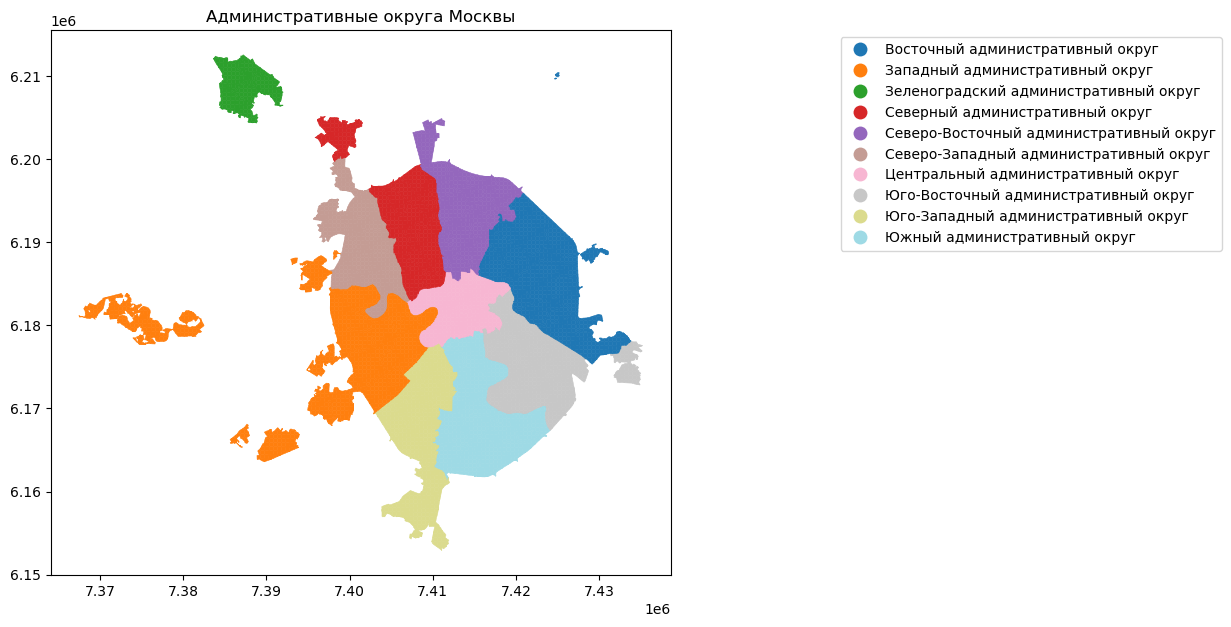

In [45]:
fig, ax = plt.subplots(1, figsize=(8,8))
gdf.plot(ax=ax, column='okrug_name', cmap='tab20', alpha=1, legend=True, edgecolor="face", linewidth=0.4)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.9, 0.))
plt.title('Административные округа Москвы', fontsize=12)
plt.show()

In [46]:
gdf.head()

,WKT,cell_zid,adm_name,okrug_name,sub_ter,geometry,area
78465,MULTIPOLYGON (((37.5909752452139 55.4915041101...,74440,Южное Бутово,Юго-Западный административный округ,Старая Москва,"MULTIPOLYGON (((7411055.508 6152952.189, 74110...",14.262198
78468,MULTIPOLYGON (((37.5910753737949 55.4914636032...,74441,Южное Бутово,Юго-Западный административный округ,Старая Москва,"MULTIPOLYGON (((7411061.745 6152947.552, 74110...",308.630341
79141,MULTIPOLYGON (((37.5798584259841 55.4960034538...,75061,Южное Бутово,Юго-Западный административный округ,Старая Москва,"MULTIPOLYGON (((7410363.130 6153467.358, 74105...",15654.273487
79144,MULTIPOLYGON (((37.5831708099274 55.4946613844...,75062,Южное Бутово,Юго-Западный административный округ,Старая Москва,"MULTIPOLYGON (((7410569.411 6153313.686, 74105...",161186.772228
79146,MULTIPOLYGON (((37.5910754670712 55.4915040388...,75063,Южное Бутово,Юго-Западный административный округ,Старая Москва,"MULTIPOLYGON (((7411061.842 6152952.053, 74110...",122120.658914


In [47]:
districts = gdf.loc[:, ['cell_zid','adm_name', 'okrug_name', 'area']]
districts.columns = ['zid','adm_name', 'okrug_name', 'area'] 
districts.head()

,zid,adm_name,okrug_name,area
78465,74440,Южное Бутово,Юго-Западный административный округ,14.262198
78468,74441,Южное Бутово,Юго-Западный административный округ,308.630341
79141,75061,Южное Бутово,Юго-Западный административный округ,15654.273487
79144,75062,Южное Бутово,Юго-Западный административный округ,161186.772228
79146,75063,Южное Бутово,Юго-Западный административный округ,122120.658914


### Добавление информации, рассчитанной по секторам

In [48]:
data_frames = [districts, home_and_work, median_customers_cnt_loc,
               median_customers_cnt_work, day_night, customers_to_work]

In [49]:
info = reduce(lambda  left, right: pd.merge(left, right, on=['zid'], how='left'), data_frames)

In [50]:
info.head()

,zid,adm_name,okrug_name,area,home_and_work,weekdays_loc,weekends_loc,weekdays_work,weekends_work,day,night,ratio_day_night,to_work
0,74440,Южное Бутово,Юго-Западный административный округ,14.262198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74441,Южное Бутово,Юго-Западный административный округ,308.630341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75061,Южное Бутово,Юго-Западный административный округ,15654.273487,235.0,168.87625,177.875000,84.03625,35.015625,549.0,760.0,0.722368,0.967290
3,75062,Южное Бутово,Юго-Западный административный округ,161186.772228,19.0,20.56375,22.453125,8.11375,3.859375,59.0,87.0,0.678161,0.964286
4,75063,Южное Бутово,Юго-Западный административный округ,122120.658914,19.0,9.81375,9.953125,83.16750,45.359375,296.0,136.0,2.176471,1.129032


In [51]:
a = info.groupby(['okrug_name', 'adm_name']).agg('sum').reset_index().drop('to_work', axis=1)
b = info.groupby(['okrug_name', 'adm_name']).agg({'to_work':'mean'}).reset_index()
info = a.join(b['to_work'])

info['area_km'] = info['area']/10**6   # площадь в кв.км

In [52]:
info.head()

,okrug_name,adm_name,zid,area,home_and_work,weekdays_loc,weekends_loc,weekdays_work,weekends_work,day,night,ratio_day_night,to_work,area_km
0,Восточный административный округ,Богородское,6728054,8.837877e+06,16958.0,32668.39125,33336.265625,9642.61125,5842.203125,63496.0,131385.0,32.685020,1.015595,8.837877
1,Восточный административный округ,Вешняки,6622261,1.067618e+07,16279.0,33530.30875,34320.375000,8725.13500,5791.140625,60371.0,133803.0,31.079802,1.005435,10.676182
2,Восточный административный округ,Восточное Измайлово,2880733,3.857702e+06,9780.0,22047.52750,22423.687500,6086.26250,4088.593750,38044.0,85148.0,8.403943,1.039667,3.857702
3,Восточный административный округ,Восточный,4002853,3.387800e+06,680.0,2182.66750,2285.062500,616.51375,375.671875,4526.0,9204.0,7.955613,0.930480,3.387800
4,Восточный административный округ,Гольяново,9848458,1.439190e+07,24156.0,47691.53750,49268.687500,12289.02375,8111.390625,85342.0,184974.0,40.884531,1.002435,14.391900


### Добавление информации из геоданных

In [53]:
count_objects = [food, art, education, health, service, office, shops, public_bank, public_police, public_post, houses,
                 kindergarden, schools]
names = ['food', 'art', 'education', 'health', 'service', 'office', 'shops', 'public_bank', 'public_police', 'public_post',
         'houses', 'kindergarden', 'schools']
for i in range(len(count_objects)):
    a = count_objects[i].reset_index().groupby('adm_name')['index'].count().reset_index()\
            .rename({'index': names[i]}, axis=1)
    info = pd.merge(info, a, on='adm_name', how='left')

In [54]:
area_objects = [residential, promzona_area, commertial_area, parking_area, playground_area,
                residential_metro700, residential_metro2500, residential_school300, residential_playground300,
                residential_parks400, residential_kindergarden300, residential_food500, residential_art1500,
                residential_service500, residential_shops500, public_bank1500, public_police1500, public_post1500, sport,]
names = ['residential', 'promzona_area', 'commertial_area', 'parking_area', 'playground_area',
         'residential_metro700', 'residential_metro2500', 'residential_school300', 'residential_playground300',
         'residential_parks400', 'residential_kindergarden300', 'residential_food500', 'residential_art1500',
         'residential_service500', 'residential_shops500', 'public_bank1500', 'public_police1500', 'public_post1500',
         'sport']
for i in range(len(area_objects)):
    a = area_objects[i].groupby('adm_name')['area'].sum().reset_index().rename({'area': names[i]}, axis=1)
    info = pd.merge(info, a, on='adm_name', how='left')

In [55]:
info = pd.merge(info, roads.groupby('adm_name')['length'].sum().reset_index().rename({'length': 'roads'}, axis=1),
                on='adm_name', how='left')

### Добавление расчетных признаков

Добавим расчетные отношения.

In [56]:
# перечень полей с расчетом отношений
list(describe.loc[describe["Единицы измерения"] == 'ratio']['Наименование признака'])

['ratio_day_night',
 'ratio_weekdays_loc_work',
 'ratio_weekends_loc_work',
 'ratio_promzona_residential',
 'ratio_commertial_residential',
 'ratio_metro700_residential',
 'ratio_metro2500_residential',
 'ratio_school300_residential',
 'ratio_playground300_residential',
 'ratio_parks400_residential',
 'ratio_kindergarden300_residential',
 'ratio_art1500_residential',
 'ratio_service500_residential',
 'ratio_shops500_residential',
 'ratio_public_bank1500',
 'ratio_public_police1500',
 'ratio_public_post1500']

In [57]:
info['ratio_day_night'] = info['day'] / info['night']
info['ratio_weekdays_loc_work'] = info['weekdays_loc'] / info['weekdays_work']
info['ratio_weekends_loc_work'] = info['weekends_loc'] / info['weekends_work']
info['ratio_promzona_residential'] = info['promzona_area'] / info['residential']
info['ratio_commertial_residential'] = info['commertial_area'] / info['residential']
info['ratio_metro700_residential'] = info['residential_metro700'] / info['residential']
info['ratio_metro2500_residential'] = info['residential_metro2500'] / info['residential']
info['ratio_school300_residential'] = info['residential_school300'] / info['residential']
info['ratio_playground300_residential'] = info['residential_playground300'] / info['residential']
info['ratio_parks400_residential'] = info['residential_parks400'] / info['residential']
info['ratio_kindergarden300_residential'] = info['residential_kindergarden300'] / info['residential']
info['ratio_art1500_residential'] = info['residential_art1500'] / info['residential']
info['ratio_service500_residential'] = info['residential_service500'] / info['residential']
info['ratio_shops500_residential'] = info['residential_shops500'] / info['residential']
info['ratio_public_bank1500'] = info['public_bank1500'] / info['residential']
info['ratio_public_police1500'] = info['public_police1500'] / info['residential']
info['ratio_public_post1500'] = info['public_post1500'] / info['residential']

Далее расчитаем значения на 1000 человек. 

Для двух признаков `kindergarden` (детские сады) и `schools` (школы) в нормативах указаны количество мест на 1000 чел., однако информацию о местах по каждой школе и детскому саду не удалось найти в открытом доступе, примем условную наполняемость 300 мест для детских садов и 800 мест для школ.

In [58]:
info['kindergarden'] = info['kindergarden'] * 300
info['schools'] = info['schools'] * 800

In [59]:
# список полей, которые надо пересчитать на 1000 человек
col = list(describe.loc[describe["Условная размерность"] == 'на 1000 человек']['Наименование признака'])
col

['home_and_work',
 'parking_area',
 'playground_area',
 'kindergarden',
 'food',
 'art',
 'education',
 'schools',
 'health',
 'service',
 'office',
 'shops',
 'public_bank',
 'public_police',
 'public_post',
 'sport',
 'houses']

In [60]:
info[col] = info[col].transform(lambda x: x*1000/info['night'])

In [61]:
info['home_and_work']

0      129.071051
1      121.663939
2      114.858834
3       73.880921
4      130.591326
          ...    
120    119.904847
121    127.797974
122    137.233624
123    142.906122
124    126.158151
Name: home_and_work, Length: 125, dtype: float64

Далее пересчитаем автомобильные дороги в км/кв.км

In [62]:
info['roads'] = info['roads'] / 1000   # перевод м в км
info[['roads']] = info[['roads']].transform(lambda x: x/info['area_km'])   # км/кв.м

In [63]:
info.shape

(125, 63)

In [64]:
info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 124
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   okrug_name                         125 non-null    object 
 1   adm_name                           125 non-null    object 
 2   zid                                125 non-null    int32  
 3   area                               125 non-null    float64
 4   home_and_work                      125 non-null    float64
 5   weekdays_loc                       125 non-null    float64
 6   weekends_loc                       125 non-null    float64
 7   weekdays_work                      125 non-null    float64
 8   weekends_work                      125 non-null    float64
 9   day                                125 non-null    float64
 10  night                              125 non-null    float64
 11  ratio_day_night                    125 non-null    float64

В признаках, сформированных по геоданным, есть пропуски. Они связаны с тем, что геоданные с OpenStreetMap были скачаны в неполном объеме. Это обнаружилось довольно поздно, поэтому придется удалить поля с пропусками и провести ранжирование по оставшимся районам. Но исследование можно масштабировать на другие районы после формирования информации в полном объеме.

In [65]:
gdf_districts = gdf_districts.merge(info, on='adm_name', how='left')

In [66]:
info = info.dropna().reset_index(drop=True)

In [67]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   okrug_name                         98 non-null     object 
 1   adm_name                           98 non-null     object 
 2   zid                                98 non-null     int32  
 3   area                               98 non-null     float64
 4   home_and_work                      98 non-null     float64
 5   weekdays_loc                       98 non-null     float64
 6   weekends_loc                       98 non-null     float64
 7   weekdays_work                      98 non-null     float64
 8   weekends_work                      98 non-null     float64
 9   day                                98 non-null     float64
 10  night                              98 non-null     float64
 11  ratio_day_night                    98 non-null     float64
 

In [68]:
# очистка памяти
del [shops, service, schools, food, residential, public_post, public_police, public_bank, office, health, education,
     sport, art, playground_area, promzona_area, commertial_area, parking_area, kindergarden, roads, houses,
     residential_metro2500, residential_service500, residential_school300, residential_art1500, residential_shops500,
     residential_playground300, public_bank1500, residential_food500, public_police1500, residential_parks400,
     public_post1500, residential_metro700, residential_kindergarden300]
gc.collect()

18

## Ранжирование районов по каждой сфере

Ранжирование районов будет проведено по следующей схеме:
- предварительная кластеризация для определения оптимального количества кластеров с помощью кривой "метода локтя", которая показывает значение целевой функции, это значение сначала резко уменьшается, а затем выходит на плато. Этот момент перехода как раз отражает оптимальное количество кластеров.
- кластеризация с определенным количеством кластеров.
- ранжирование полученных кластеров по величине среднего значения показателя по принципу, чем выше показатель, тем выше ранг. Этот принцип можно применить, т.к. все признаки для кластеризации были изначально так сформированы.
- отображение на картограмме полученных классов: класс 1 - лучший показатель по самообеспеченности, класс n - худший показатель.

In [81]:
def clusters(sphere):
    data = info[sphere]
    scaler = StandardScaler()
    data_transform = scaler.fit_transform(data)
    
    distortion = []
    K = range(1, 16)
    for k in K:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(data_transform)
        distortion.append(model.inertia_) 
    
    plt.figure(figsize=(10, 4))
    plt.plot(K, distortion, 'bx-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Значение целевой функции')
    plt.show() 
    
    return data

In [82]:
def clustering(data, n_clusters, lable, sphere):
    pipe = Pipeline([("scaler", StandardScaler()),
                     ("kmeans", KMeans(n_clusters=n_clusters, random_state=42))
                    ])
    pipe.fit(data)
    
    data[lable] = pipe["kmeans"].labels_
    
    means = data.groupby(lable)[sphere].mean()
    means_T = means.T.round(3)
    means_T = pd.DataFrame(means_T)
    means_T.reset_index(inplace=True)

    colors = ["red", "blue", "green", "brown", "orange", "purple", 'yellow', 'pink']


    # графики для кластеров
    fig, ax = plt.subplots(1, n_clusters, figsize=(15,6), sharey=True, sharex=True)
    axis = ax.flatten()

    for i, col  in enumerate(means_T.columns):
        if col != "index":
            ax = axis[i-1]
            ax.bar(height=means_T[col], x=means_T["index"], color=colors[i-1])
            ax.set_xticklabels(labels=means_T["index"], rotation=90)
            ax.set_title(f"Кластер {col}", fontsize=20)
            
    info[lable] = pipe["kmeans"].labels_

In [155]:
# картограмма
def carto(column, title):
    fig, ax = plt.subplots(1, figsize=(12,6))
    gdf_districts.plot(ax=ax, column=column, cmap='plasma', categorical=True, alpha=1, legend=True)
    leg = ax.get_legend()
    plt.title(title, fontsize=12)
    plt.show()

### Сфера образования

In [84]:
education = list(describe.loc[(describe["Использование признака"] == 'кластеризация') & (describe["Сфера"] == 'образование'),
                     'Наименование признака'])
len(education)

3

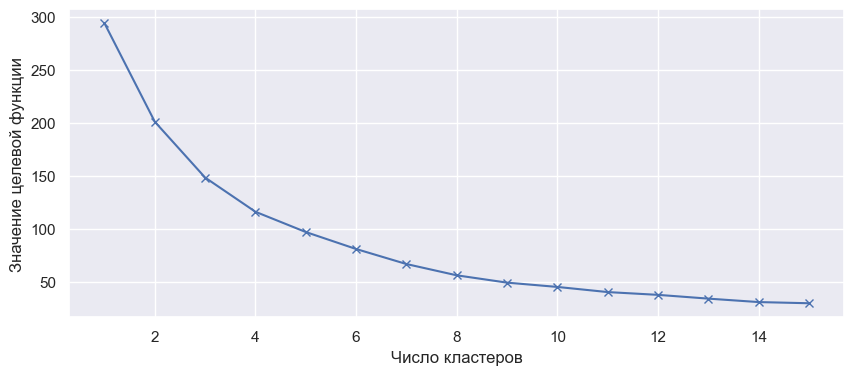

In [85]:
data_education = clusters(education)

Четкого перегиба в кривой не наблюдается. Примем количество классов равное 5.

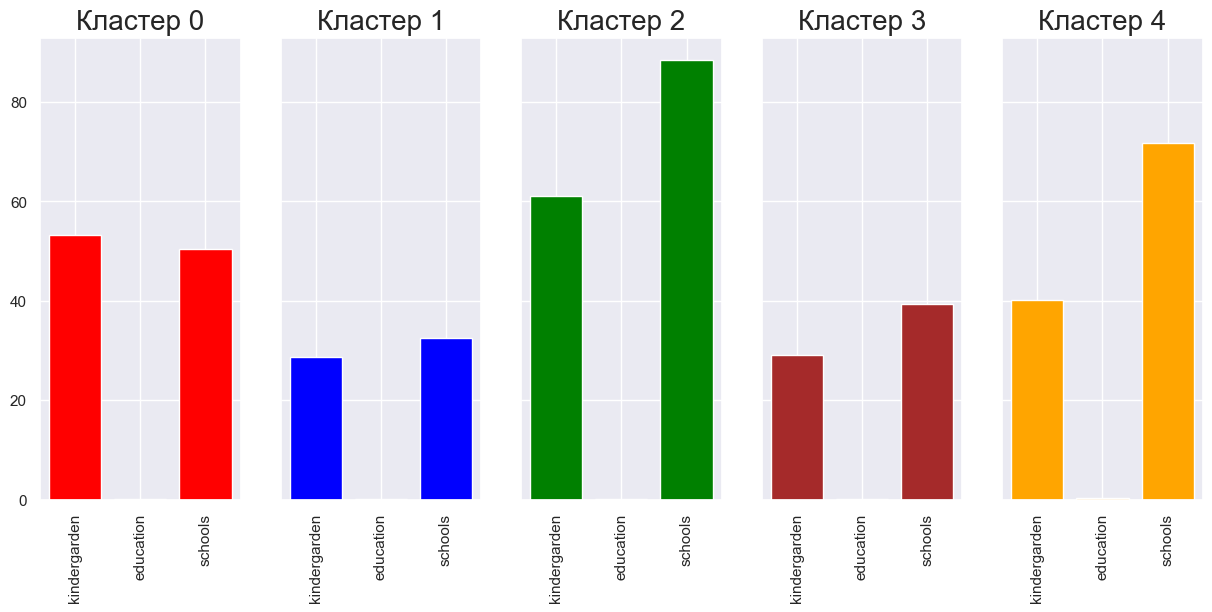

In [86]:
clustering(data=data_education, n_clusters=5, lable='educat_label', sphere=education)

Один признак "просел" из-за того, что размерность признаков не совпадает (не удалось найти нужную информацию для расчета количества мест). Школы и детские сады в количестве мест на 1000 жителей, а объекты образования в количестве объектов на тысячу жителей. 

Класс 1 в данном случае очевиден - это кластер 2. Средние показатели по двум признакам выше, чем в других кластерах.

Далее присвоим классы всем кластерам на основе средних показателей признаков.

In [87]:
gdf_districts = gdf_districts.merge(info[['adm_name', 'educat_label']], on='adm_name', how='left')

In [88]:
def education_range(predicted_cluster):
    if predicted_cluster == 2:
        return 'класс 1'
    elif predicted_cluster == 4:
        return 'класс 2'
    elif predicted_cluster == 0:
        return 'класс 3'
    elif predicted_cluster == 3:
        return 'класс 4'
    elif predicted_cluster == 1:
        return 'класс 5'

In [89]:
gdf_districts['educat_label'] = gdf_districts['educat_label'].apply(education_range)

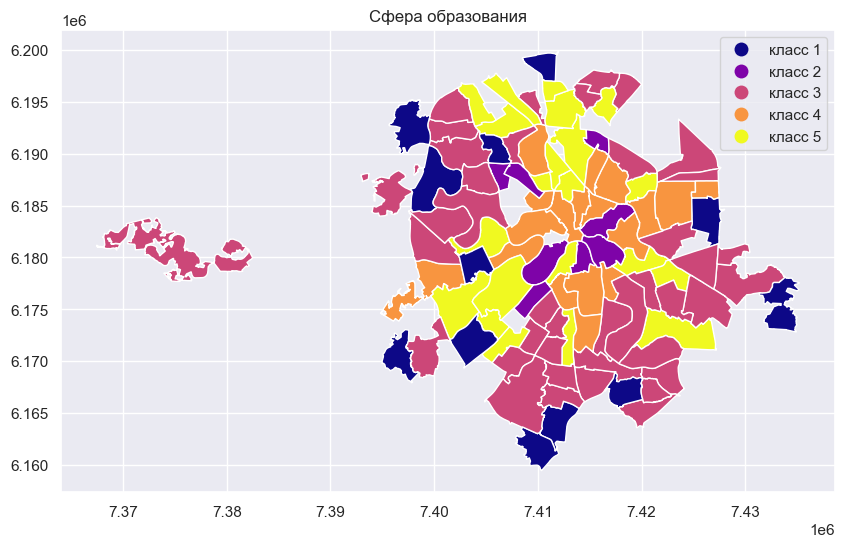

In [156]:
carto(column='educat_label', title='Сфера образования')

### Социальная сфера

In [91]:
socio = list(describe.loc[(describe["Использование признака"] == 'кластеризация') & (describe["Сфера"] == 'социальная'),
                     'Наименование признака'])
len(socio)

12

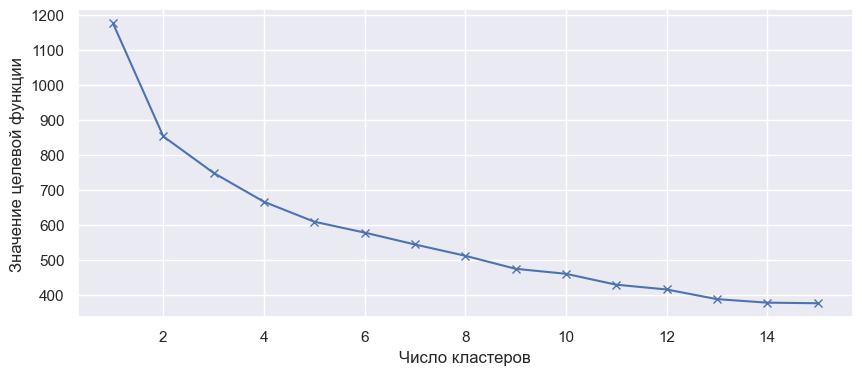

In [92]:
data_socio = clusters(socio)

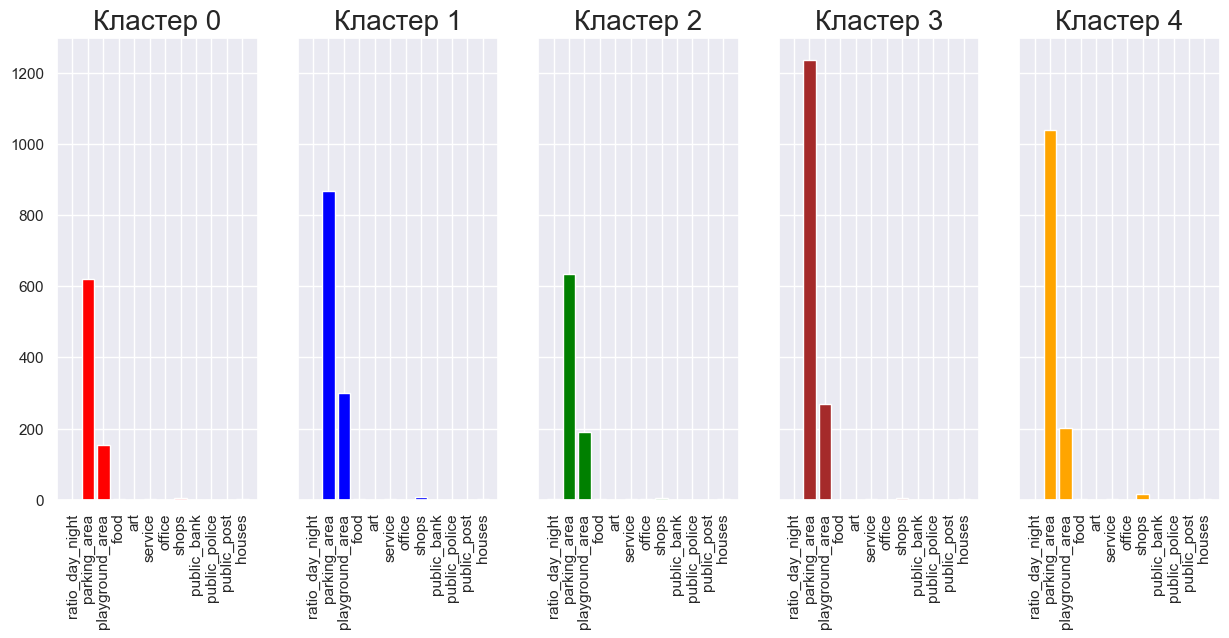

In [100]:
clustering(data=data_socio, n_clusters=5, lable='socio_label', sphere=socio)

In [101]:
gdf_districts = gdf_districts.merge(info[['adm_name', 'socio_label']], on='adm_name', how='left')

In [102]:
def socio_range(predicted_cluster):
    if predicted_cluster == 3:
        return 'класс 1'
    elif predicted_cluster == 4:
        return 'класс 2'
    elif predicted_cluster == 1:
        return 'класс 3'
    elif predicted_cluster == 2:
        return 'класс 4'
    elif predicted_cluster == 0:
        return 'класс 5'

In [103]:
gdf_districts['socio_label'] = gdf_districts['socio_label'].apply(socio_range)

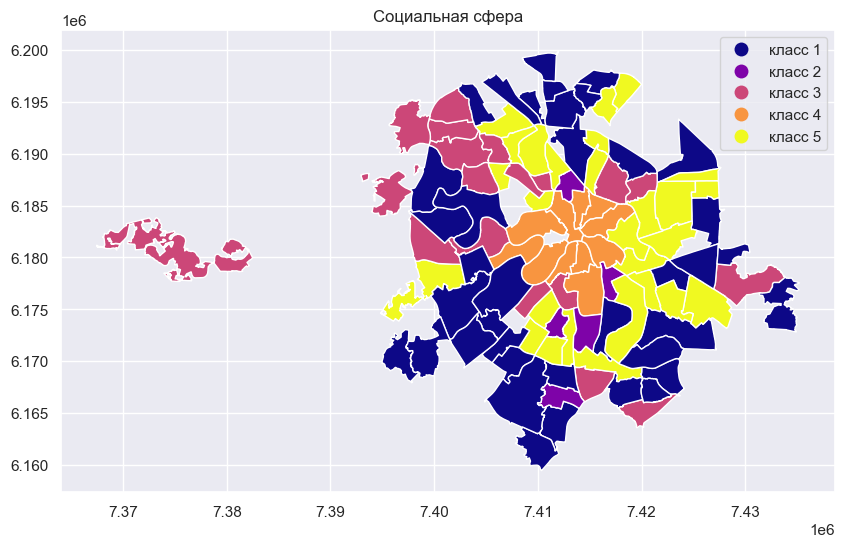

In [157]:
carto(column='socio_label', title='Социальная сфера')

### Транспорт

In [105]:
transport = list(describe.loc[(describe["Использование признака"] == 'кластеризация') & (describe["Сфера"] == 'транспорт'),
                     'Наименование признака'])
len(transport)

1

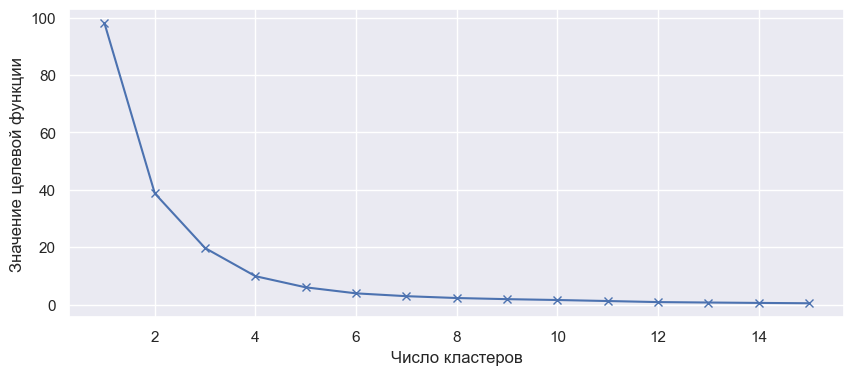

In [106]:
data_transport = clusters(transport)

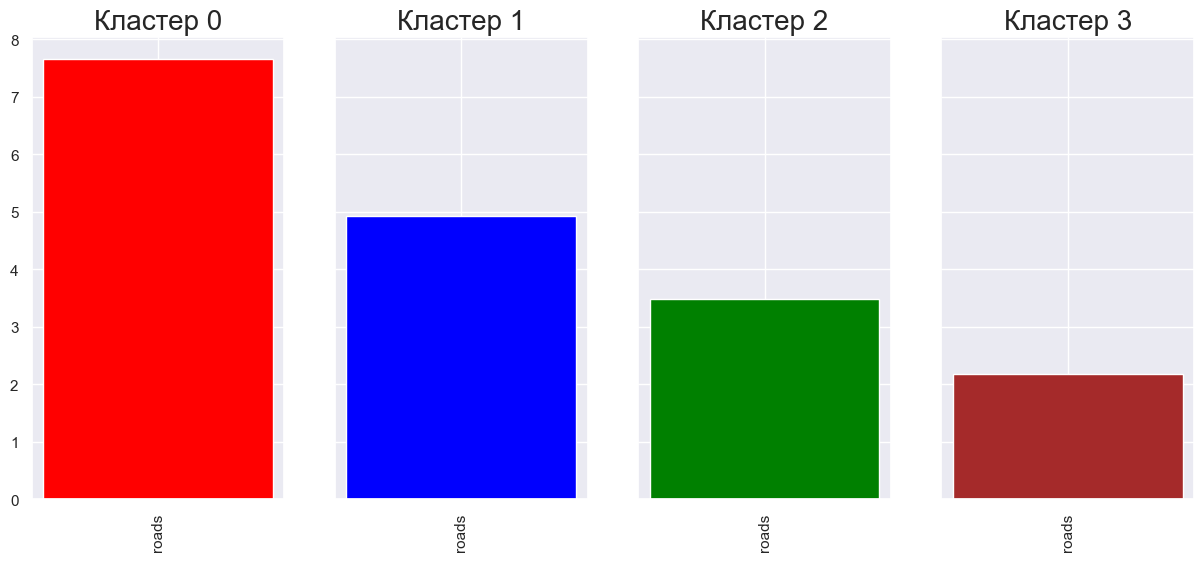

In [107]:
clustering(data=data_transport, n_clusters=4, lable='transport_label', sphere=transport)

In [108]:
gdf_districts = gdf_districts.merge(info[['adm_name', 'transport_label']], on='adm_name', how='left')

In [109]:
def transport_range(predicted_cluster):
    if predicted_cluster == 0:
        return 'класс 1'
    elif predicted_cluster == 1:
        return 'класс 2'
    elif predicted_cluster == 2:
        return 'класс 3'
    elif predicted_cluster == 3:
        return 'класс 4'

In [110]:
gdf_districts['transport_label'] = gdf_districts['transport_label'].apply(transport_range)

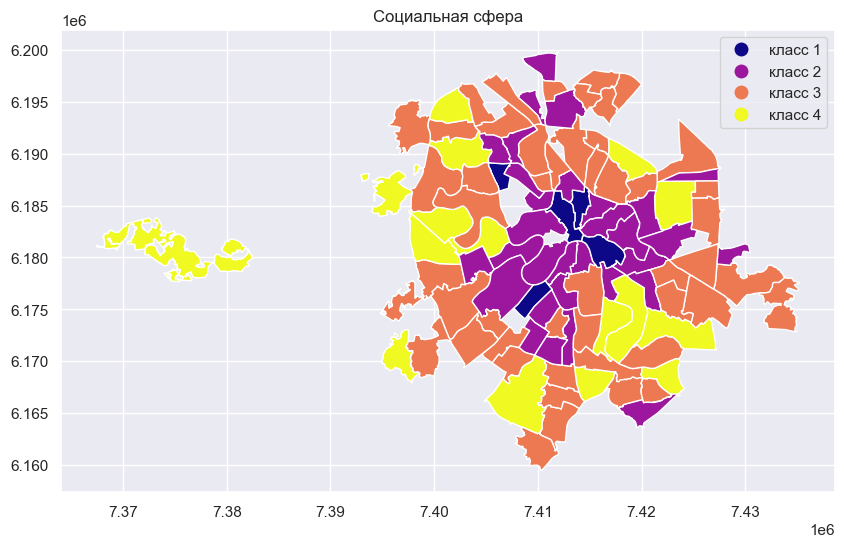

In [158]:
carto(column='transport_label', title='Социальная сфера')

### Спорт

In [112]:
sport = list(describe.loc[(describe["Использование признака"] == 'кластеризация') & (describe["Сфера"] == 'спорт'),
                     'Наименование признака'])
len(sport)

1

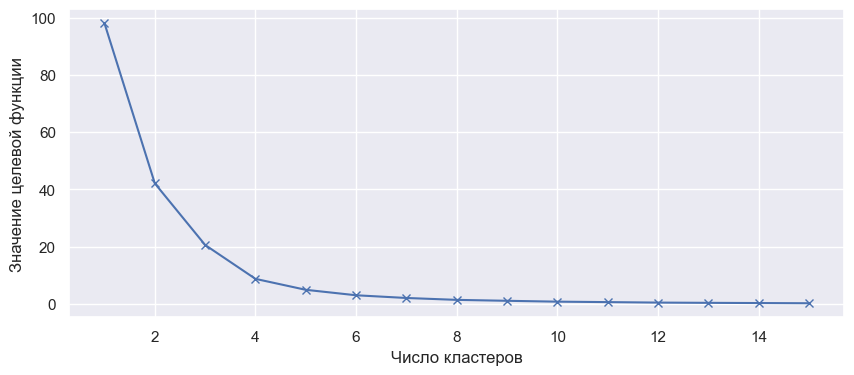

In [113]:
data_sport = clusters(sport)

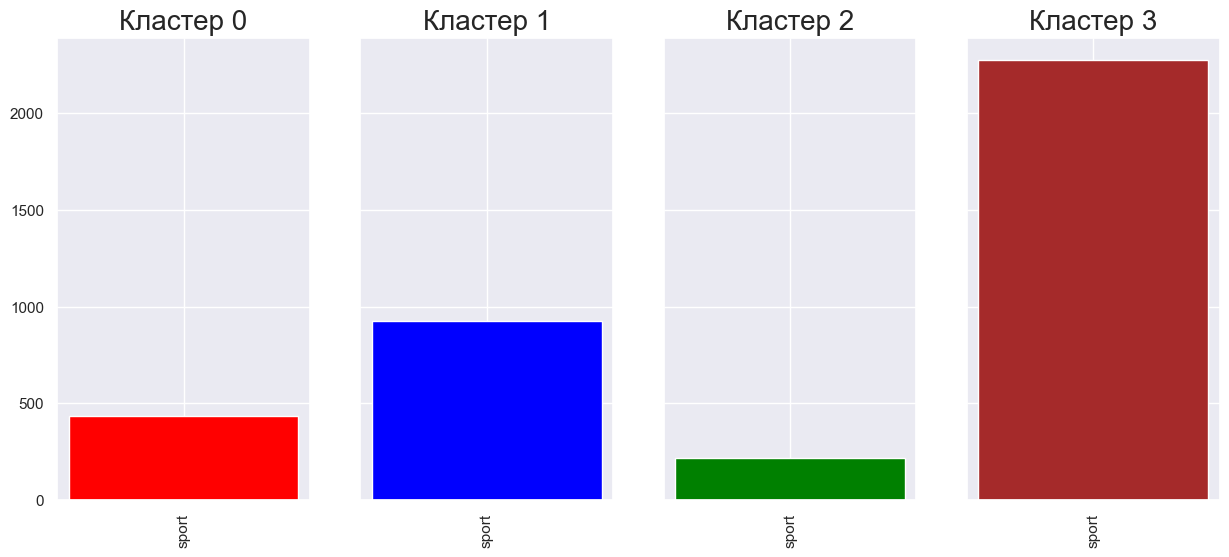

In [114]:
clustering(data=data_sport, n_clusters=4, lable='sport_label', sphere=sport)

In [115]:
gdf_districts = gdf_districts.merge(info[['adm_name', 'sport_label']], on='adm_name', how='left')

In [116]:
def sport_range(predicted_cluster):
    if predicted_cluster == 3:
        return 'класс 1'
    elif predicted_cluster == 1:
        return 'класс 2'
    elif predicted_cluster == 0:
        return 'класс 3'
    elif predicted_cluster == 2:
        return 'класс 4'

In [117]:
gdf_districts['sport_label'] = gdf_districts['sport_label'].apply(sport_range)

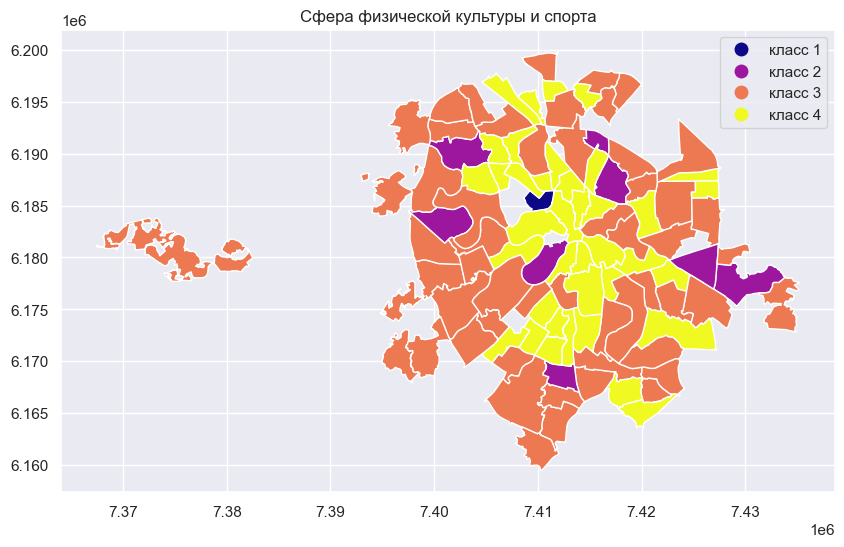

In [159]:
carto(column='sport_label', title='Сфера физической культуры и спорта')

### Здравоохранение

In [119]:
helth = list(describe.loc[(describe["Использование признака"] == 'кластеризация') & (describe["Сфера"] == 'здравоохранение'),
                     'Наименование признака'])
len(helth)

1

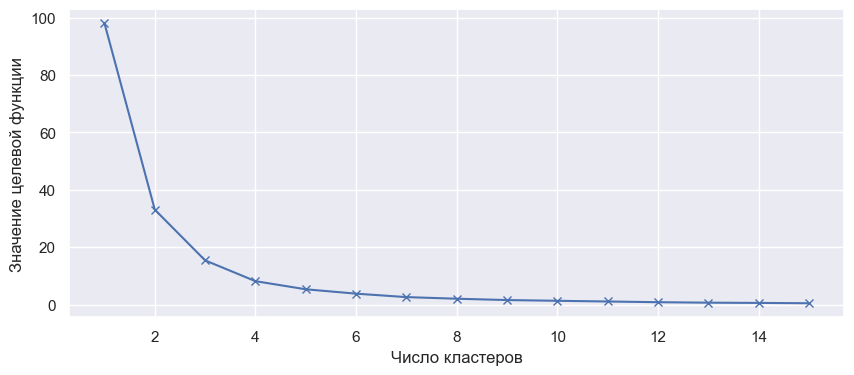

In [120]:
data_helth = clusters(helth)

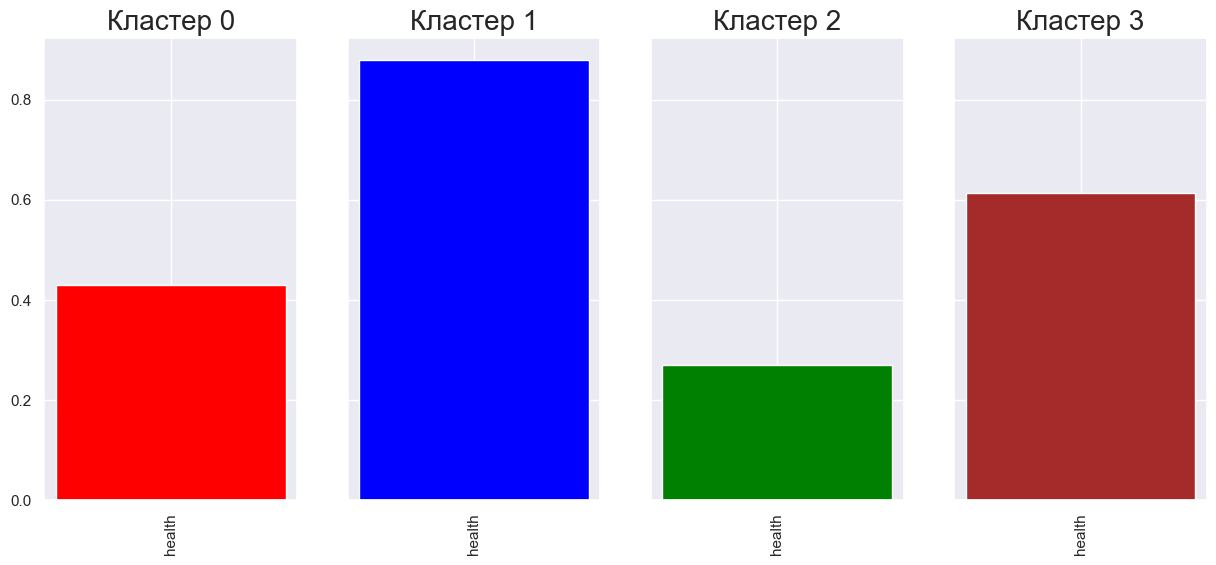

In [121]:
clustering(data=data_helth, n_clusters=4, lable='helth_label', sphere=helth)

In [122]:
gdf_districts = gdf_districts.merge(info[['adm_name', 'helth_label']], on='adm_name', how='left')

In [123]:
def helth_range(predicted_cluster):
    if predicted_cluster == 1:
        return 'класс 1'
    elif predicted_cluster == 3:
        return 'класс 2'
    elif predicted_cluster == 0:
        return 'класс 3'
    elif predicted_cluster == 2:
        return 'класс 4'

In [124]:
gdf_districts['helth_label'] = gdf_districts['helth_label'].apply(helth_range)

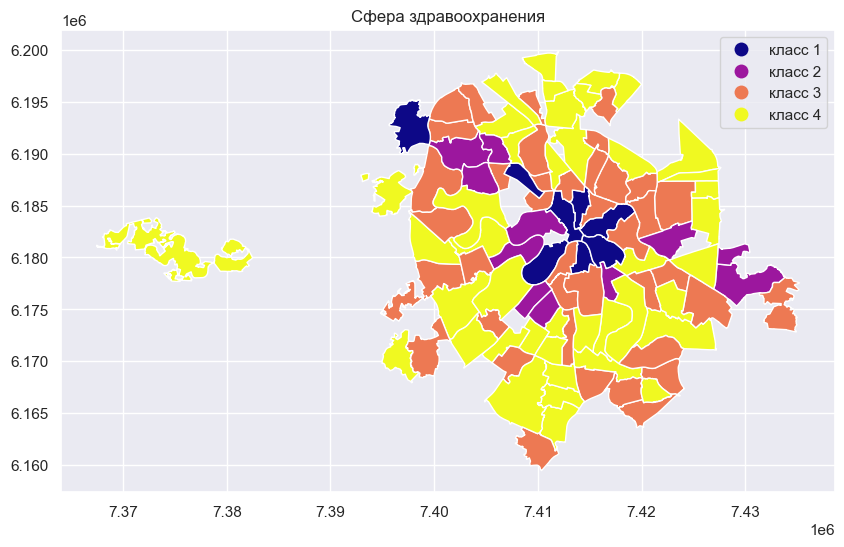

In [160]:
carto(column='helth_label', title='Сфера здравоохранения')

### Доступность объектов социальной инфраструктуры

In [126]:
availability = list(describe.loc[(describe["Использование признака"] == 'кластеризация') & (describe["Сфера"] == 'доступность'),
                     'Наименование признака'])
len(availability)

12

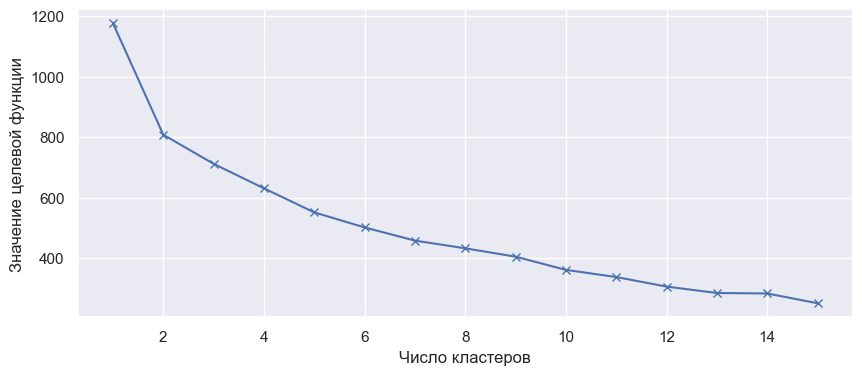

In [127]:
data_availability = clusters(availability)

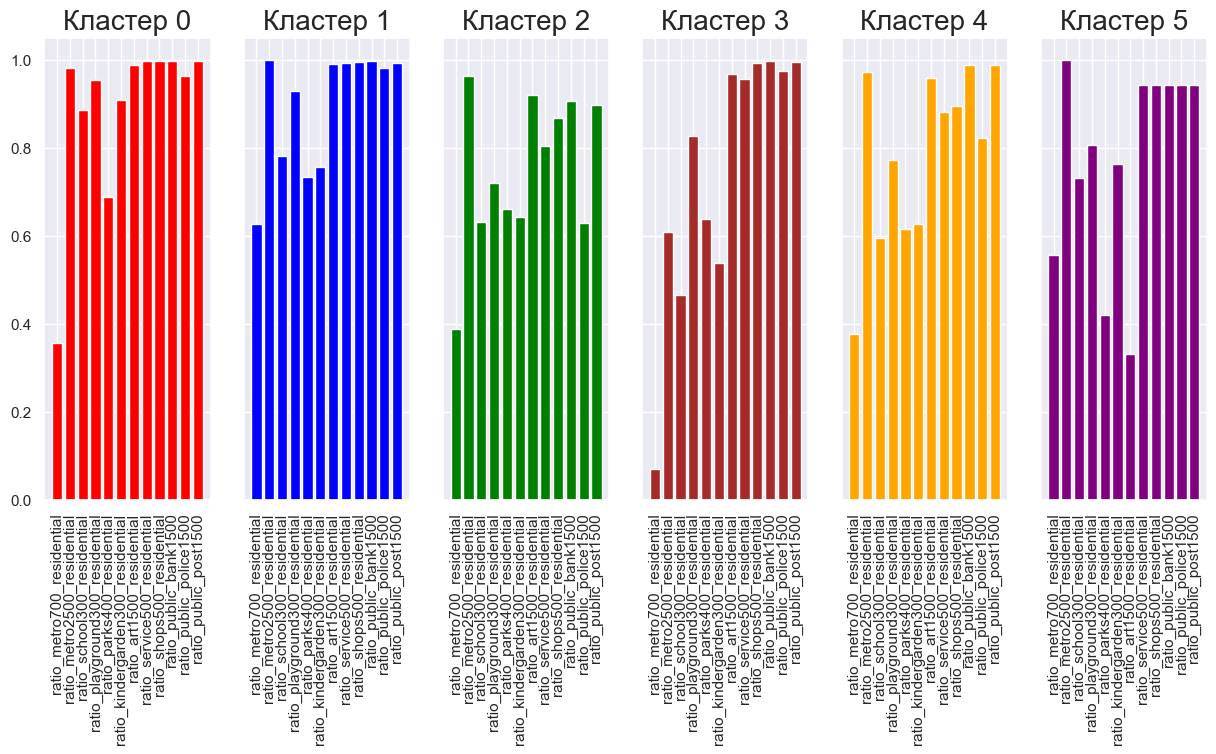

In [128]:
clustering(data=data_availability, n_clusters=6, lable='availability_label', sphere=availability)

In [129]:
gdf_districts = gdf_districts.merge(info[['adm_name', 'availability_label']], on='adm_name', how='left')

In [130]:
def availability_range(predicted_cluster):
    if predicted_cluster == 1:
        return 'класс 1'
    elif predicted_cluster == 0:
        return 'класс 2'
    elif predicted_cluster == 4:
        return 'класс 3'
    elif predicted_cluster == 2:
        return 'класс 4'
    elif predicted_cluster == 3:
        return 'класс 5'
    elif predicted_cluster == 5:
        return 'класс 6'

In [131]:
gdf_districts['availability_label'] = gdf_districts['availability_label'].apply(availability_range)

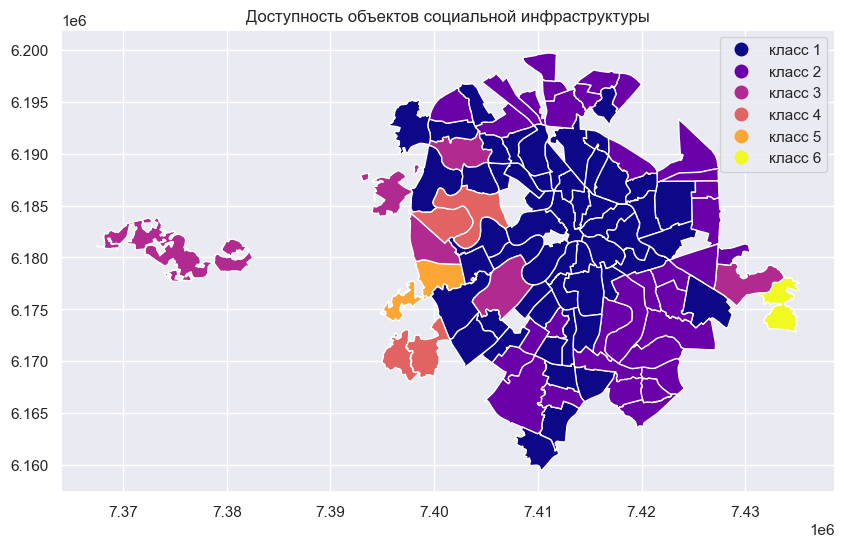

In [161]:
carto(column='availability_label', title='Доступность объектов социальной инфраструктуры')

## Итоговое ранжирование районов Москвы

Далее проведем итоговое ранжирование районов Москвы на основе полученных данных по ранжированию пяти основных сфер деятельности населения, а также по доступности социально-значимых объектов.

In [133]:
moscow = list(describe.loc[(describe["Использование признака"] == 'кластеризация') & (describe["Сфера"] == 'итог'),
                     'Наименование признака'])
moscow

['educat_label',
 'socio_label',
 'transport_label',
 'sport_label',
 'helth_label',
 'availability_label']

In [134]:
info = info.merge(gdf_districts[['educat_label', 'socio_label', 'transport_label', 'sport_label',
                                'helth_label', 'availability_label', 'adm_name']], on='adm_name', how='left')

In [135]:
def ranges(predicted_cluster):
    if predicted_cluster == 'класс 1':
        return 6
    elif predicted_cluster == 'класс 2':
        return 5
    elif predicted_cluster == 'класс 3':
        return 4
    elif predicted_cluster == 'класс 4':
        return 3
    elif predicted_cluster == 'класс 5':
        return 2
    elif predicted_cluster == 'класс 6':
        return 1

In [136]:
columns_y = ['educat_label_y', 'socio_label_y', 'transport_label_y', 'sport_label_y', 'helth_label_y',
             'availability_label_y']
for i in range(len(moscow)):
    info[moscow[i]] = info[columns_y[i]].apply(ranges)

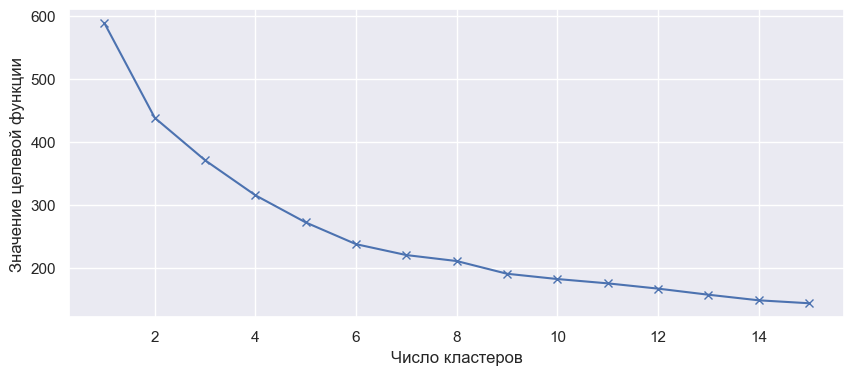

In [137]:
data_moscow = clusters(moscow)

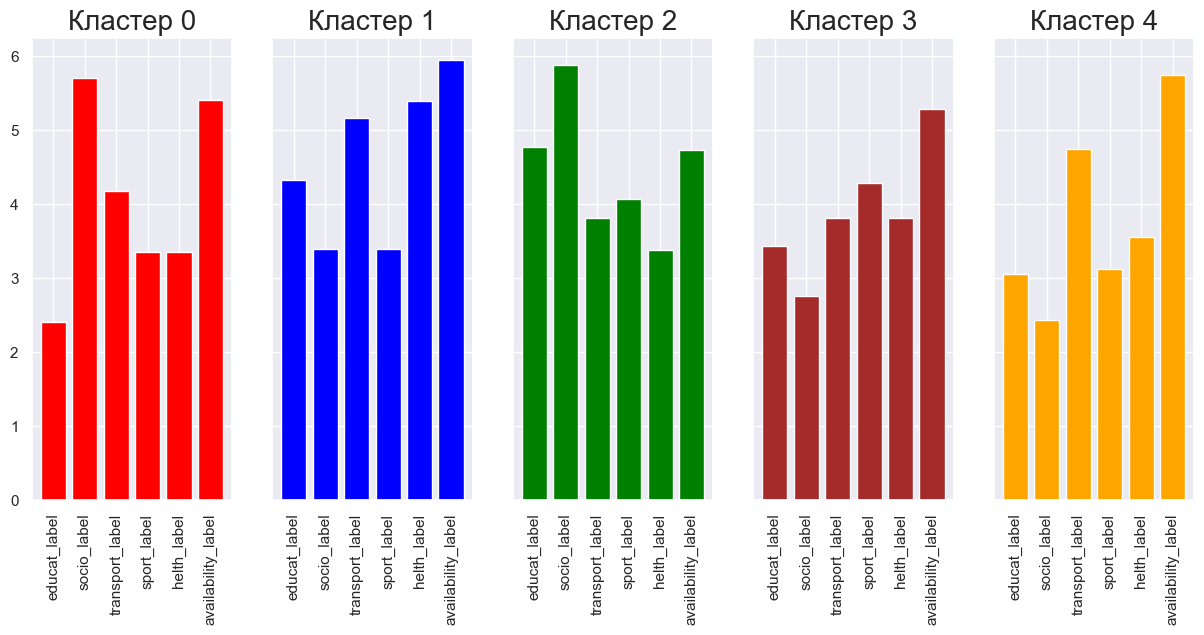

In [147]:
clustering(data=data_moscow, n_clusters=5, lable='moscow_label', sphere=moscow)

In [151]:
gdf_districts = gdf_districts.merge(info[['adm_name', 'moscow_label']], on='adm_name', how='left')

In [152]:
def moscow_range(predicted_cluster):
    if predicted_cluster == 2:
        return 'класс 1'
    elif predicted_cluster == 1:
        return 'класс 2'
    elif predicted_cluster == 0:
        return 'класс 3'
    elif predicted_cluster == 3:
        return 'класс 4'
    elif predicted_cluster == 4:
        return 'класс 5'

In [153]:
gdf_districts['moscow_label'] = gdf_districts['moscow_label'].apply(moscow_range)

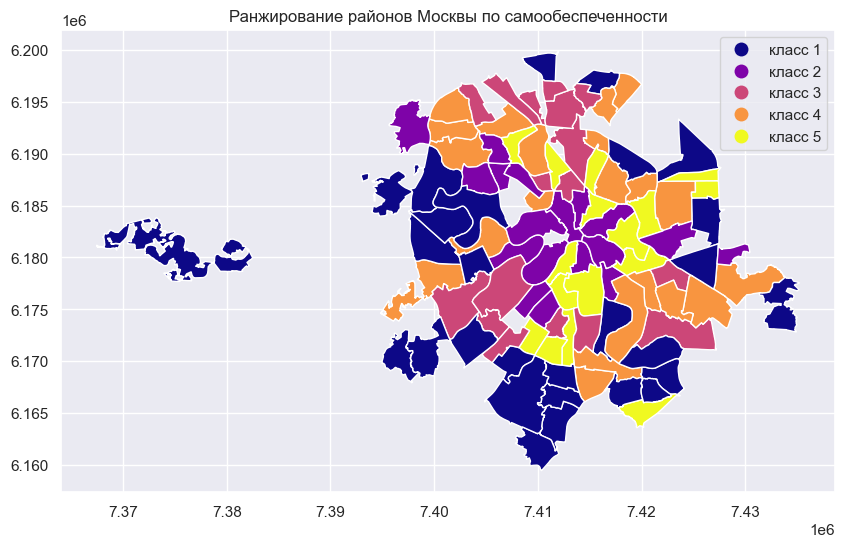

In [162]:
carto(column='moscow_label', title='Ранжирование районов Москвы по самообеспеченности')

## Общий вывод

В ходе проекта была разработана концепция ранжирования районов города по самодостаточности на основе данных из различных сфер деятельности населения, а также проведена апробация определения уровня самодостаточности на реальных данных.

Стратегия по сбору исходных данных включала в себя определение видов исходных данных (табличные и пространственные), а также подбор нескольких открытых источников данных, при этом отдавалось предпочтение официальным государственным ресурсам.

На этапе формирования признаков для исследования были изучены нормативные документы градостроительного проектирования Москвы, в соответствии с ними был составлен перечень признаков и норм для исследования. Всего было сформировано более 40 признаков.

На этапе апробации ранжирования районов были сформированы 5 классов по самодостаточности районов, где класс 1 - лучший показатель по самообеспеченности, класс 5 - худший показатель.

В ходе работы возникали трудности с поиском исходных данных, в открытых источниках часто не было данных в том виде, который наиболее подходил для исследования, приходилось изменять размерности. Размерности признаков очень важны для процесса кластеризации, желательно, чтобы они были в одной шкале, поэтому можно сказать, что изменение размерностей несколько ухудшает результаты данного исследования. Например, по многим объектам в нормах указано значение кв. м на 1000 жителей, однако такой информации нет в открытых источниках, поэтому размерность приходилось изменять на число объектов на 1000 жителей. Такое значение уже, к сожалению, не получится проверить по нормам. Однако, досбор исходных данных и приведение размерностей к нормативным, наверняка, может сделает ранжирование точнее.

Разработанная концепция ранжирования районов города основана на глубоком изучении основных сфер деятельности населения и при наличии полных и достоверных исходных данных может применяться для анализа городской среды, выявления проблемных районов. Концепция ранжирования может быть масштабирована на новые районы при наличии исходных данных, также в нее могут быть добавлены другие сферы деятельности населения.